# Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
pip install wfdb

     |████████████████████████████████| 122kB 9.1MB/s 


In [ ]:
pip install biosppy

     |████████████████████████████████| 81kB 6.0MB/s 


In [ ]:
import wfdb as wf
import os
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal
from biosppy.signals import ecg
from glob import glob
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import plot_roc_curve
from biosppy.signals.tools import filter_signal as filtsig
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold ,StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import string
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
%tensorflow_version 1.x
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.INFO)
from sklearn.utils import shuffle
from keras.utils import to_categorical
print(tf.__version__)


TensorFlow 1.x selected.
1.15.2


Using TensorFlow backend.


# Read one of INCART database datas

In [ ]:
def plot_12_lead_ecg(leads):
    name = ['I', 'II', 'III', 'AVR', 'AVL', 'AVF',
            'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
    index =1
    sample_rate=40

    # Plot 12 leads
    fig, ax = plt.subplots(nrows=6, ncols=2, figsize=(15, 20))
    leads = leads

    k = 0
    for i in range(6):
        for j in range(2):
            x = leads[:,k][:200]
            n = len(x)
            ax[i, j].plot(np.arange(0, 1.0/sample_rate * n, 1.0/sample_rate), x)
            ax[i, j].set_title(name[k])
            ax[i, j].grid()
            if i == 5:
                ax[i, j].set_xlabel('t (seconds)')
            if j == 0:
                ax[i, j].set_ylabel('x (mV)')
            k += 1
    fig.tight_layout()
    return fig

In [ ]:
# Read the file.
record = wf.rdsamp('drive/My Drive/ECG classification/Data/files/I08')
annotation = wf.rdann('drive/My Drive/ECG classification/Data/files/I08', 'atr')

# Info about the data.
print('Sampling frequency:', record[1].get('fs'))
print('Data shape:', record[0].shape)
print('Annotations:', len(annotation.num))

Sampling frequency: 257
Data shape: (462600, 12)
Annotations: 2131


## Raw Data

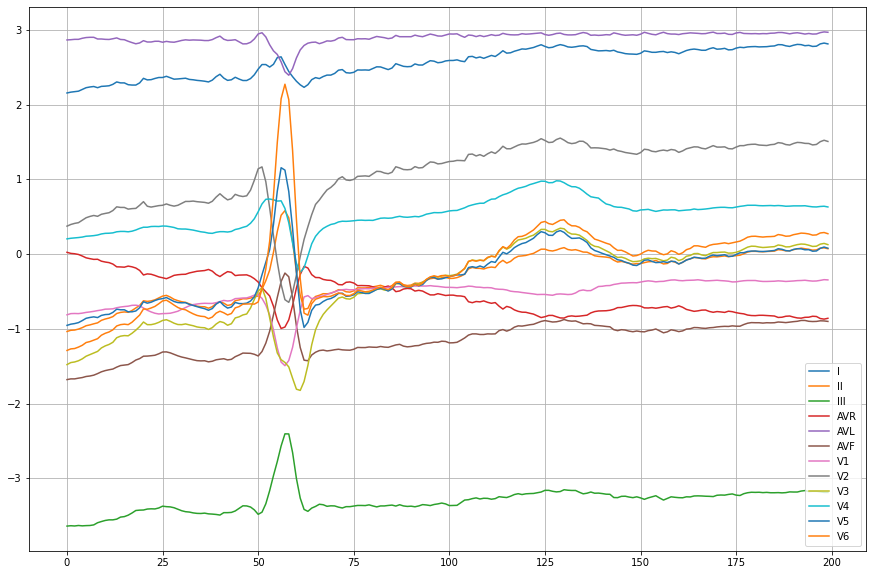

In [ ]:
name = ['I', 'II', 'III', 'AVR', 'AVL', 'AVF',
            'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
fig, ax = plt.subplots(figsize=(15, 10))
leads = record[0]
x = leads[:][:200]
n = len(x)
ax.plot(x)
ax.grid()
plt.legend(name)
plt.show()

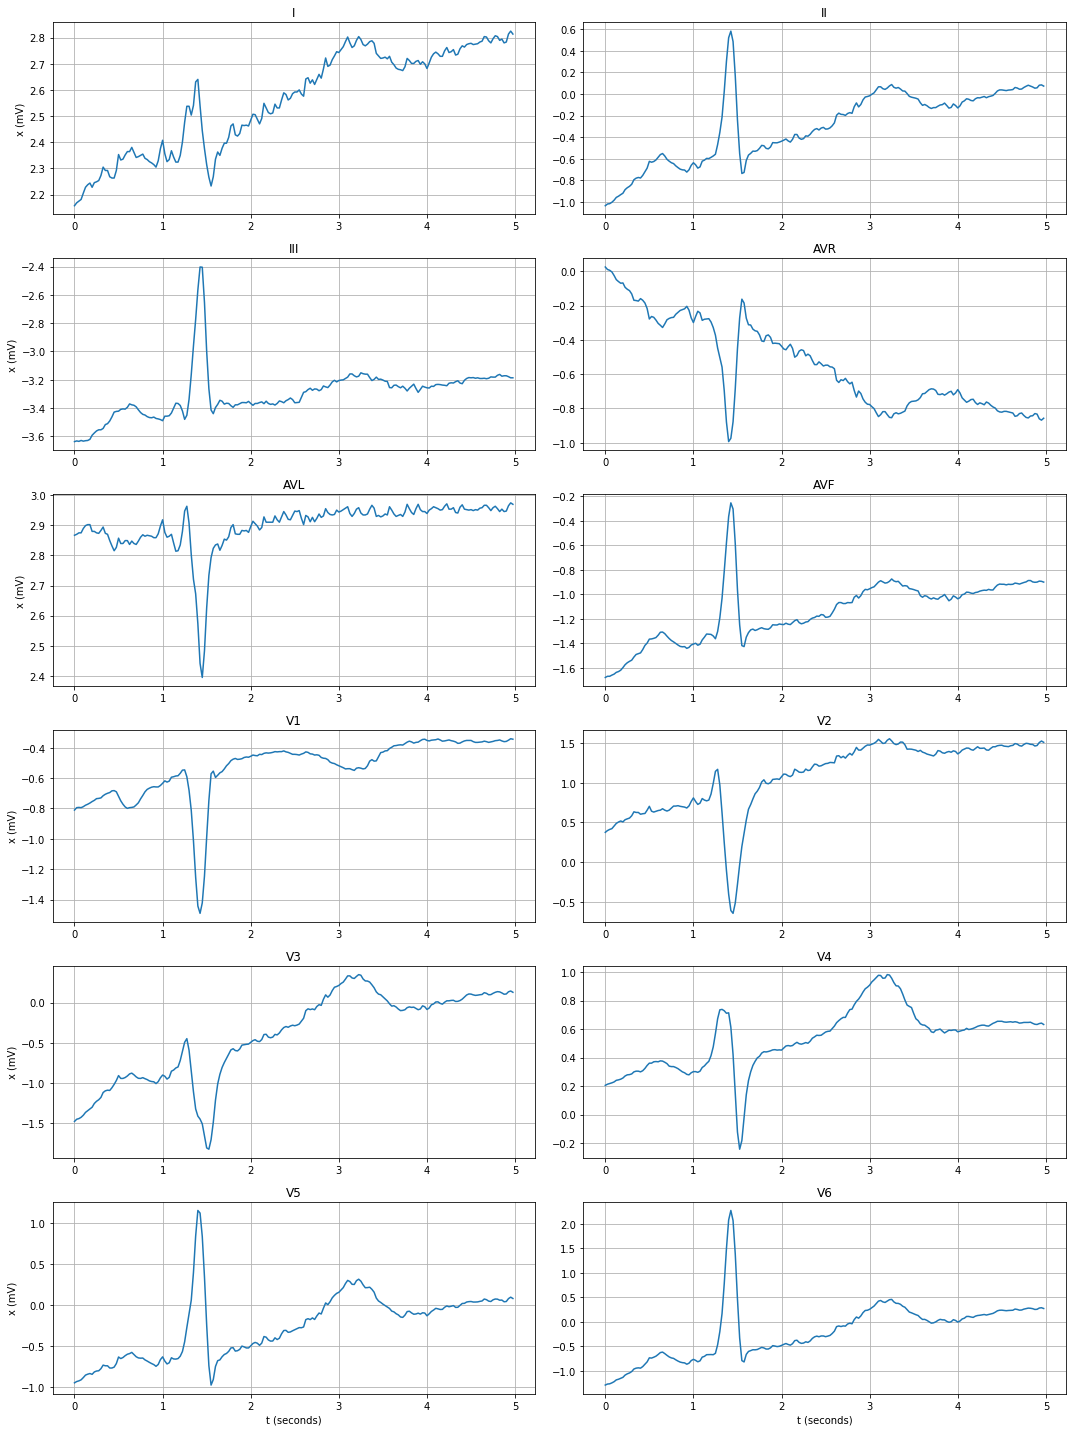

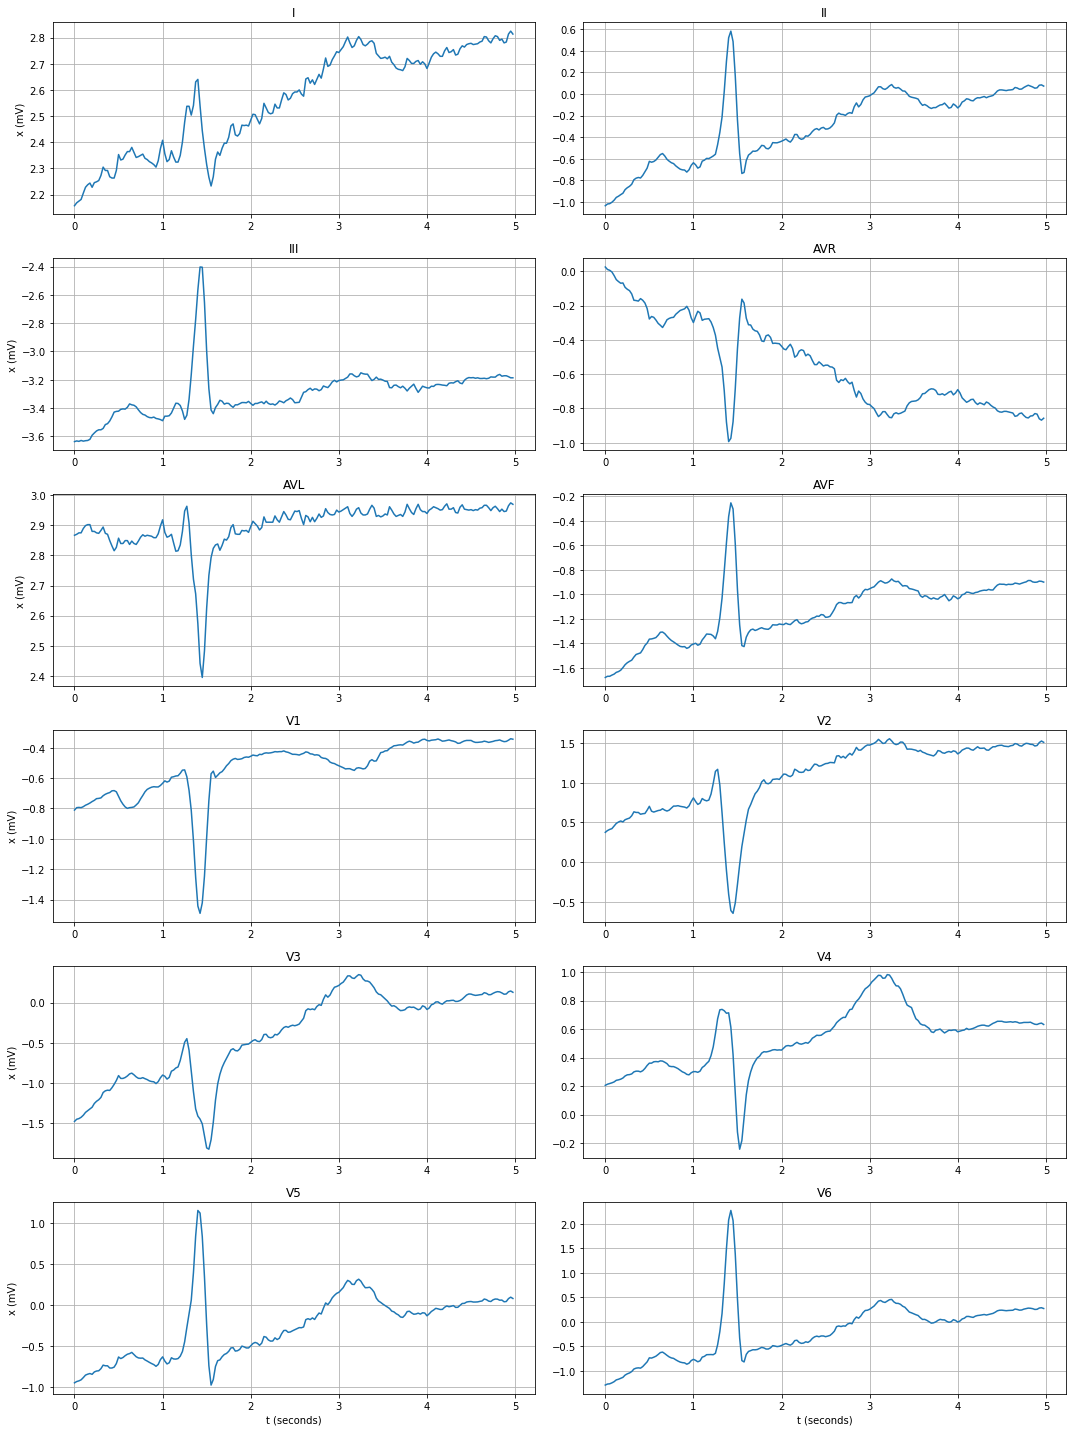

In [ ]:
plot_12_lead_ecg(record[0][:200])

## FIR Filter

In [ ]:
def FIR_filter(signal):
  data =signal.transpose()
  fir_data = np.zeros(shape=data.shape)
  for i in range(len(data)):
    out = ecg.ecg(signal=data[i], sampling_rate=257, show=False)
    fir_data[i] = out['filtered']
  fir_data = fir_data.transpose()
  return fir_data

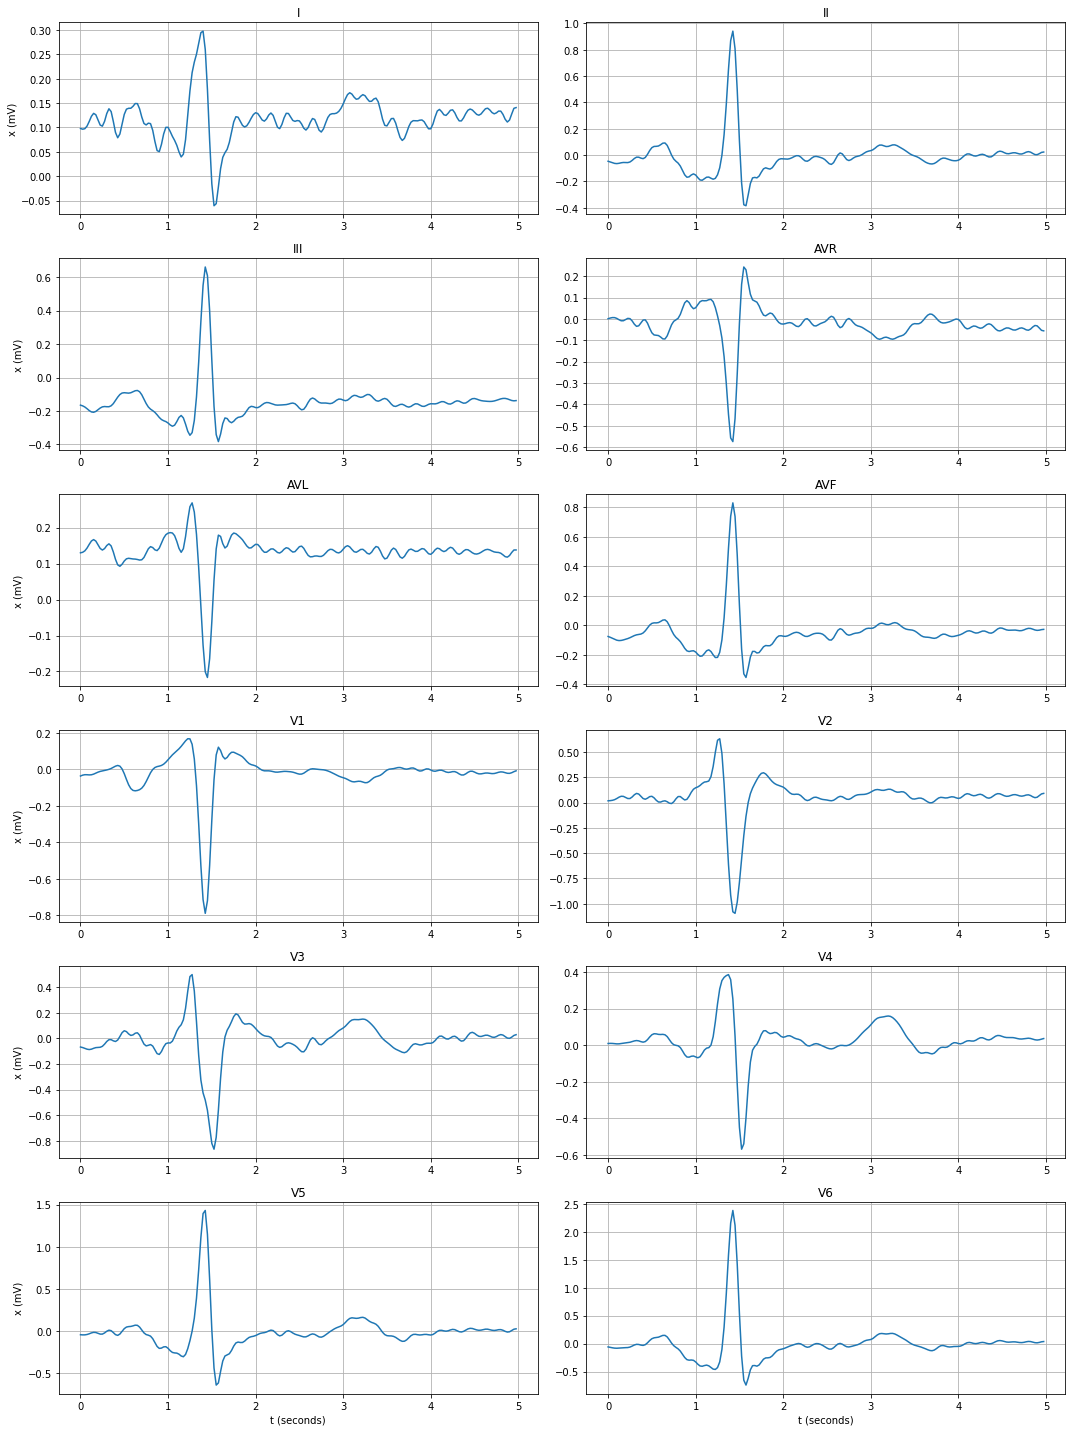

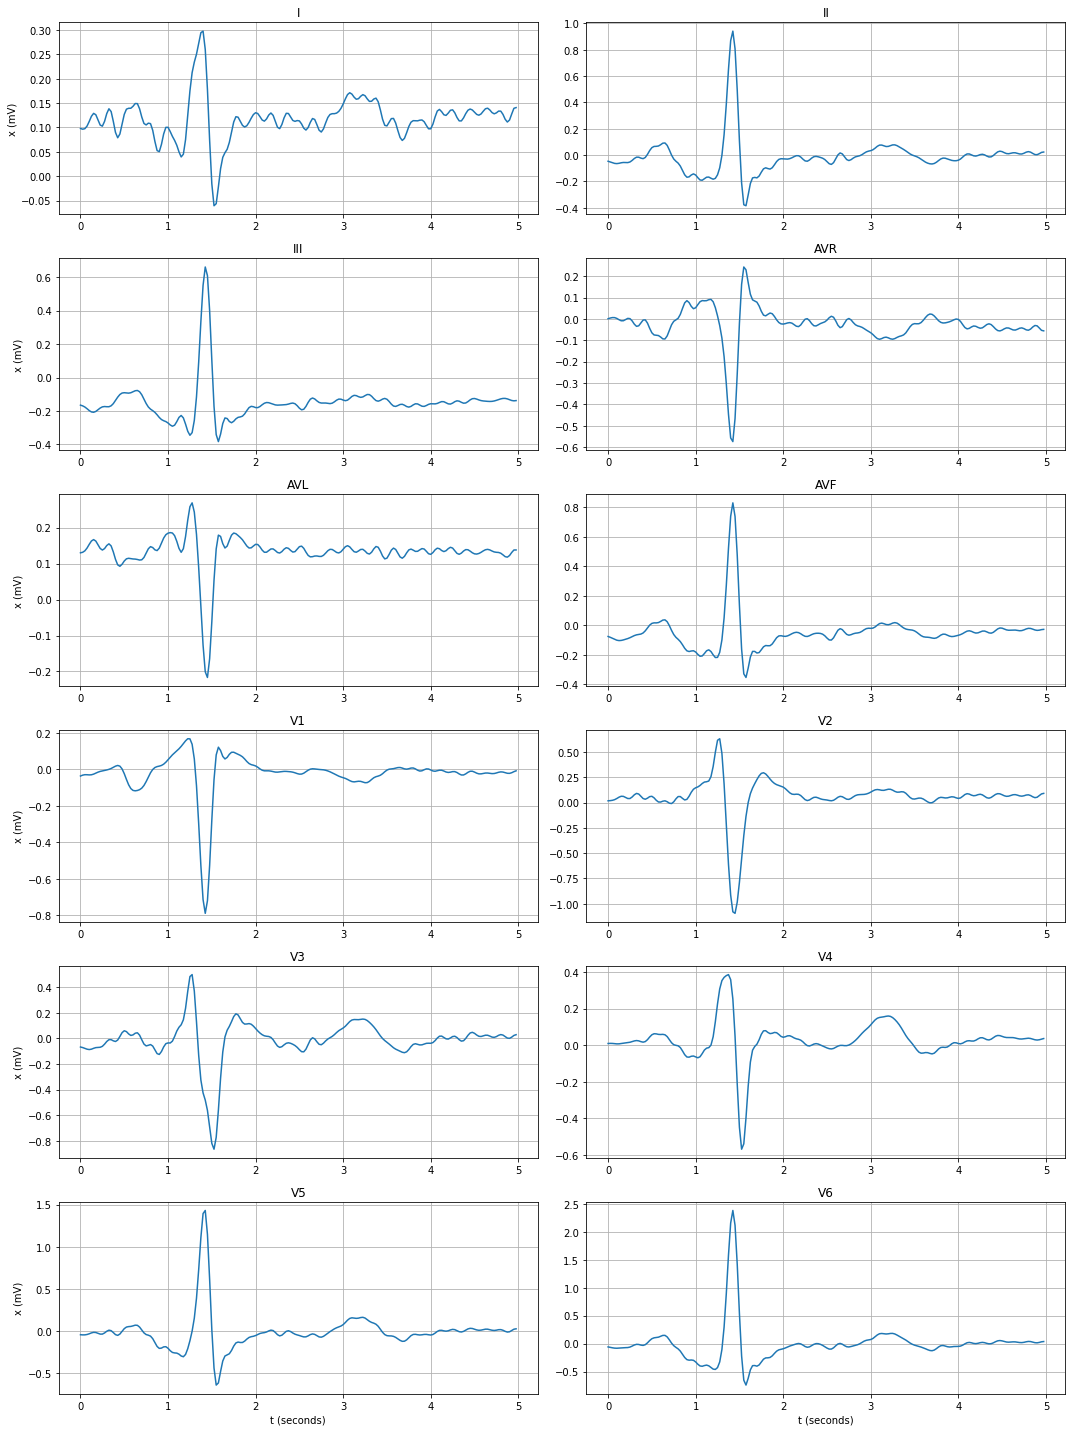

In [ ]:
fir = FIR_filter(record[0])
plot_12_lead_ecg(fir[:200])

## Bessel Filter With Lowpass

In [ ]:
def Bessel_lowpass(fir_signal):
  data = fir_signal.transpose()
  baseless = np.zeros(shape=data.shape)
  for i in range(len(data)):
    out ,_,_= filtsig(signal=data[i],ftype='bessel',order =2, frequency=0.2,sampling_rate=2,band='lowpass',)
    baseless[i] = out
  baseless =baseless.transpose()
  return baseless


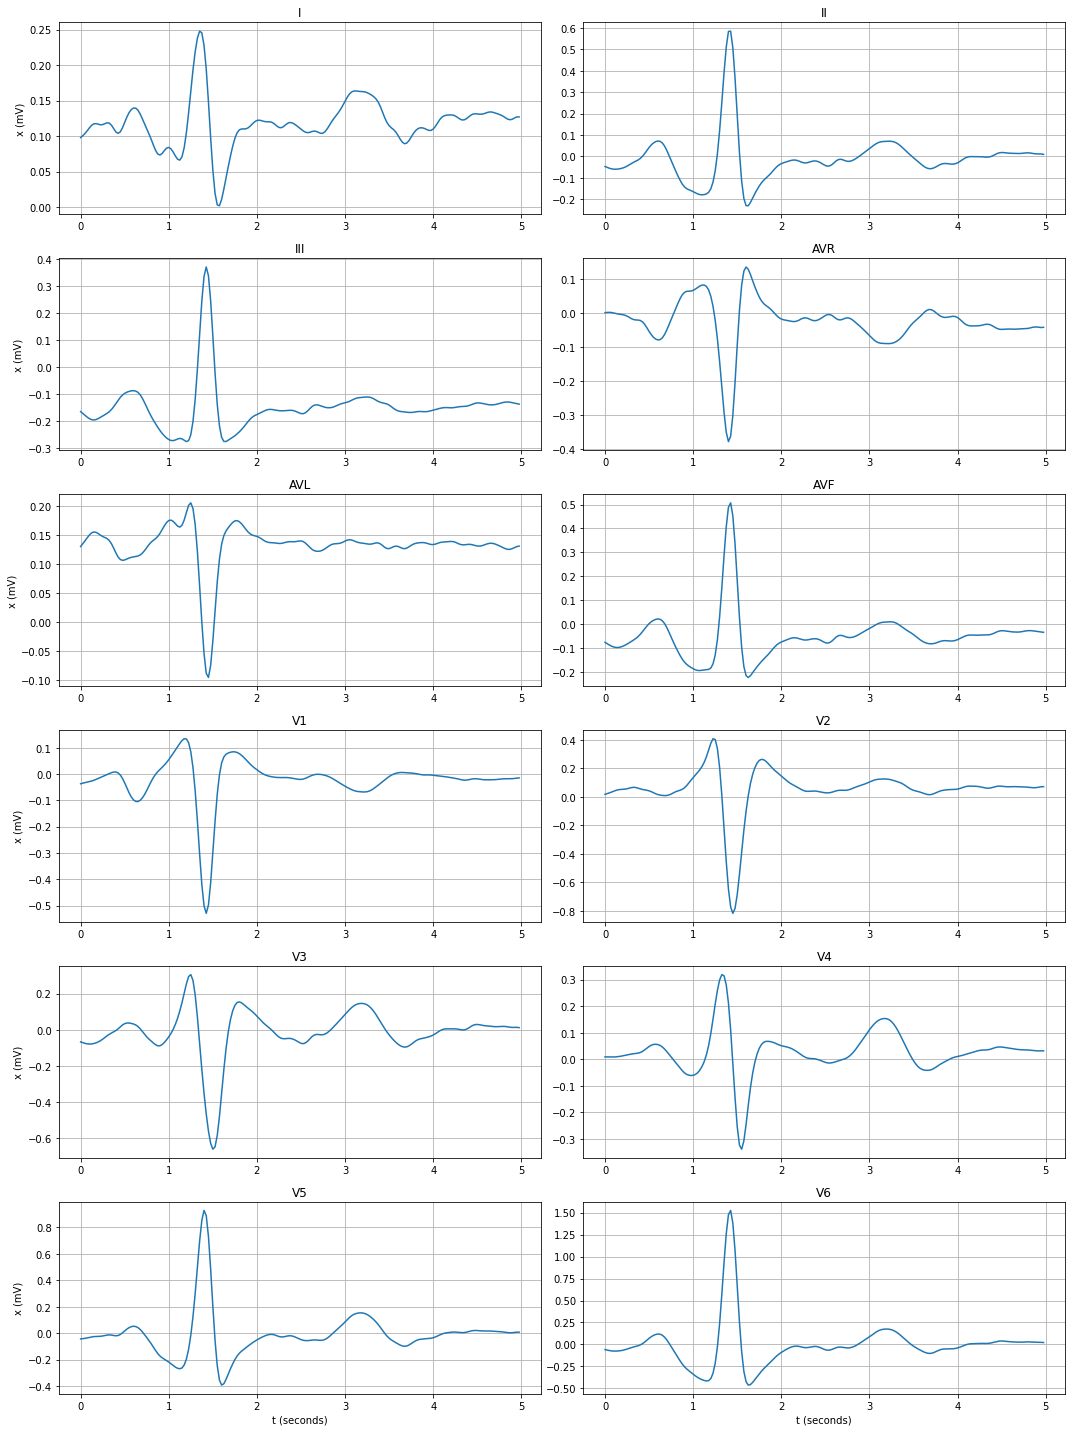

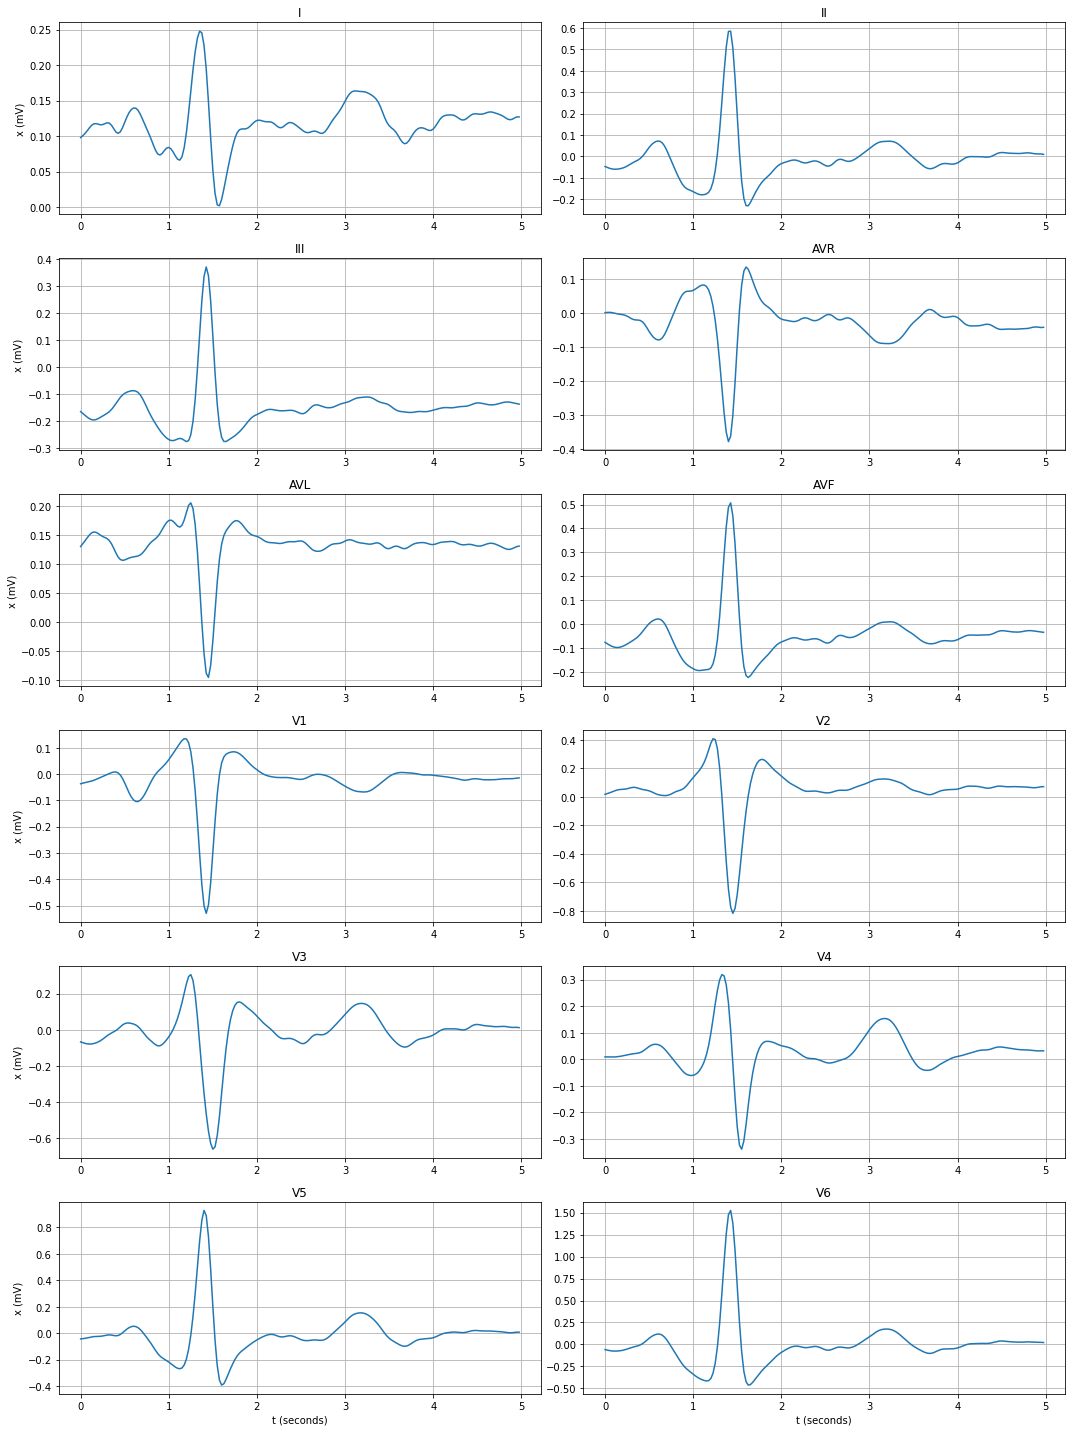

In [ ]:
bs = Bessel_lowpass(fir)
plot_12_lead_ecg(bs[:200])

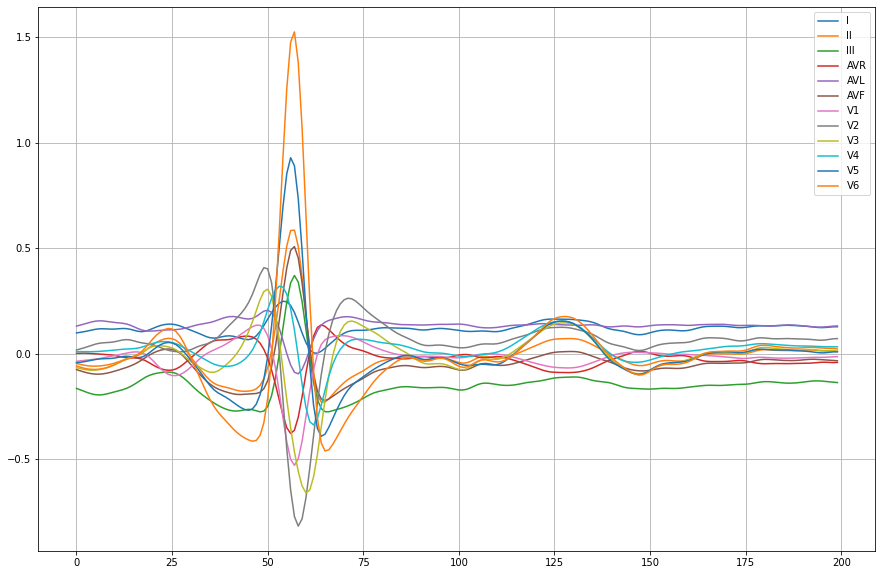

In [ ]:
name = ['I', 'II', 'III', 'AVR', 'AVL', 'AVF',
            'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
fig, ax = plt.subplots(figsize=(15, 10))
leads = bs
x = leads[:][:200]
n = len(x)
ax.plot(x)
ax.grid()
plt.legend(name)
plt.show()

In [ ]:
def Preproccess_Signals(signal):
  scaler = StandardScaler()
  data_fir = FIR_filter(signal)
  bs_data = Bessel_lowpass(data_fir)
  scaled_data = scaler.fit_transform(bs_data)
  return scaled_data


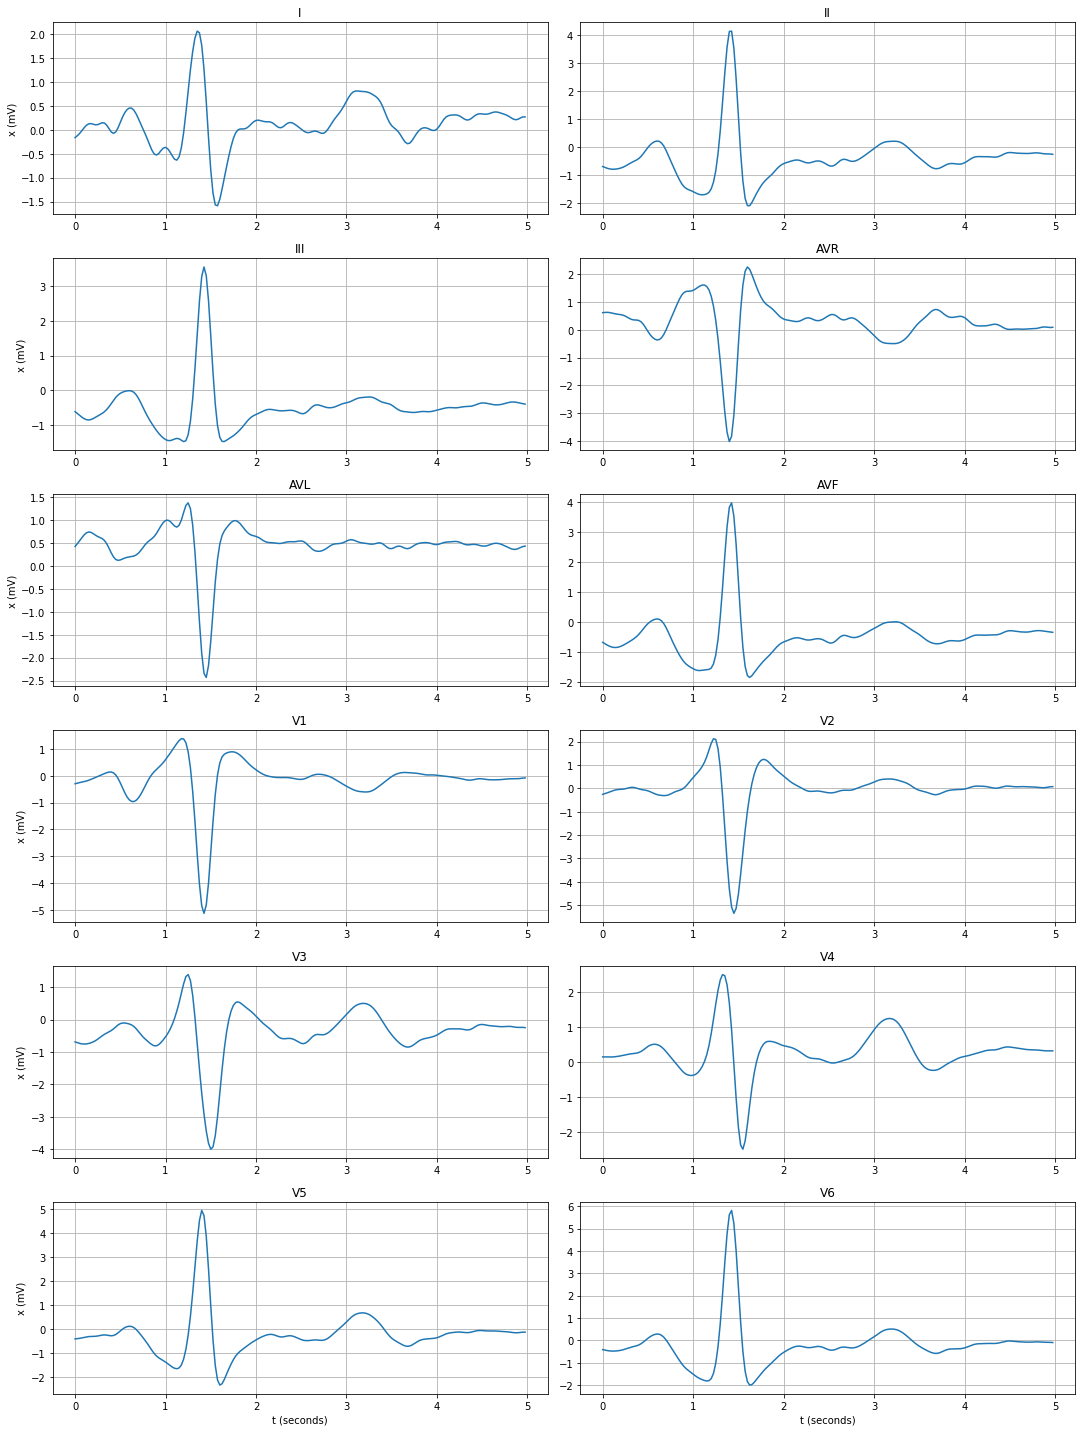

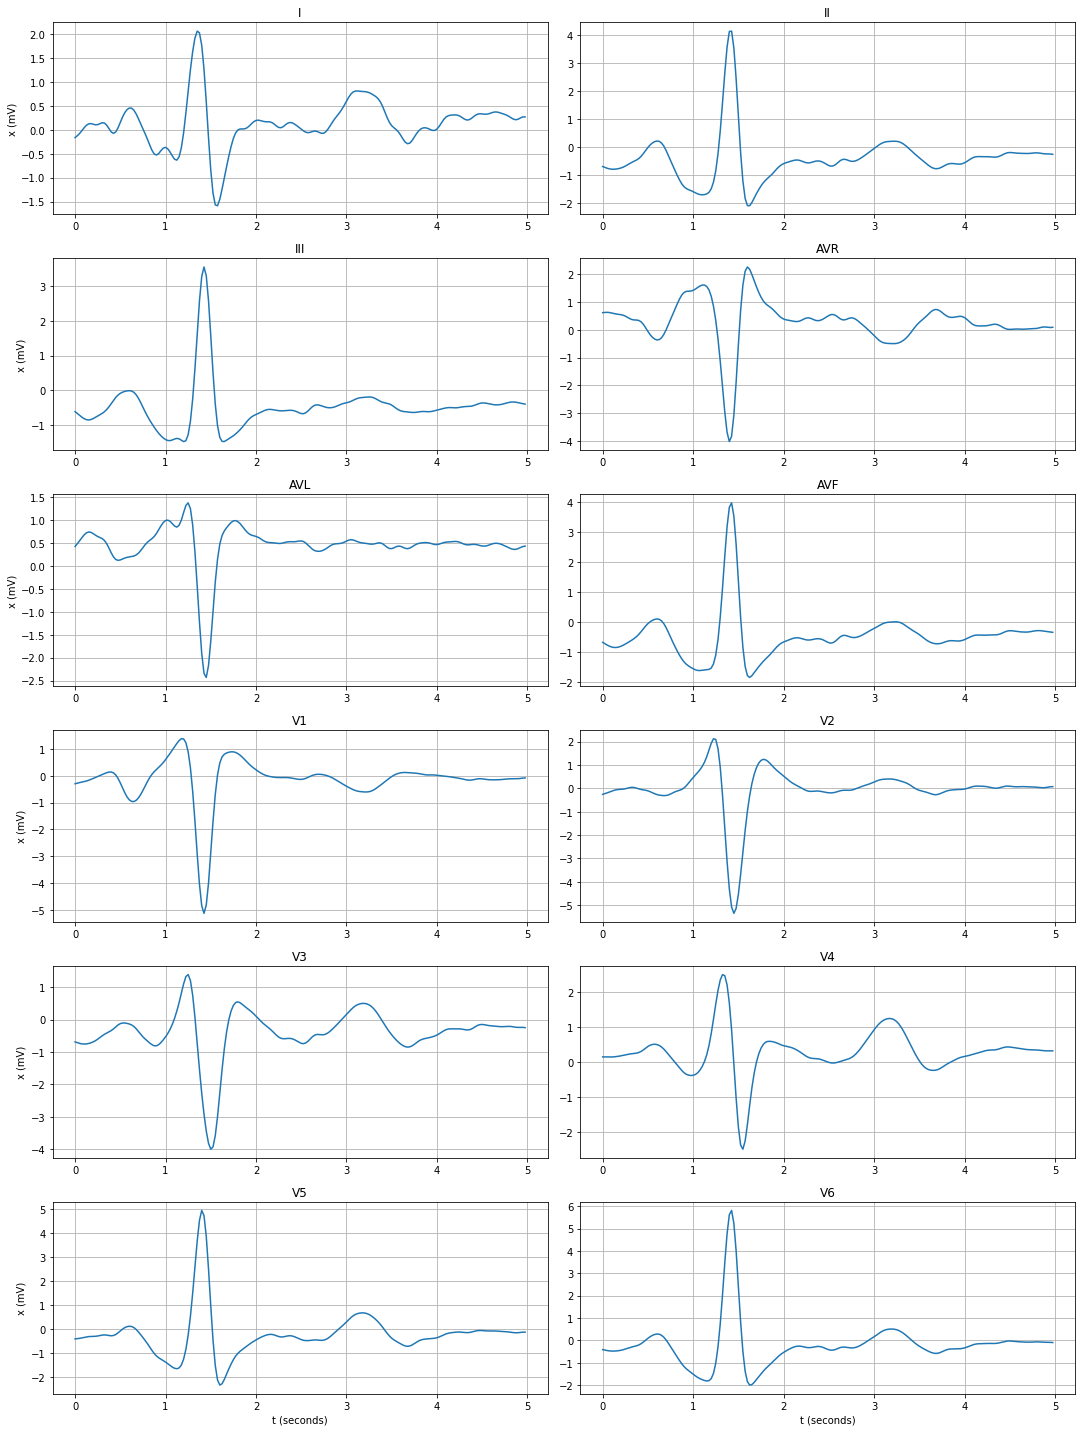

In [ ]:
prerpo_sig = Preproccess_Signals(record[0])
plot_12_lead_ecg(prerpo_sig[:200])

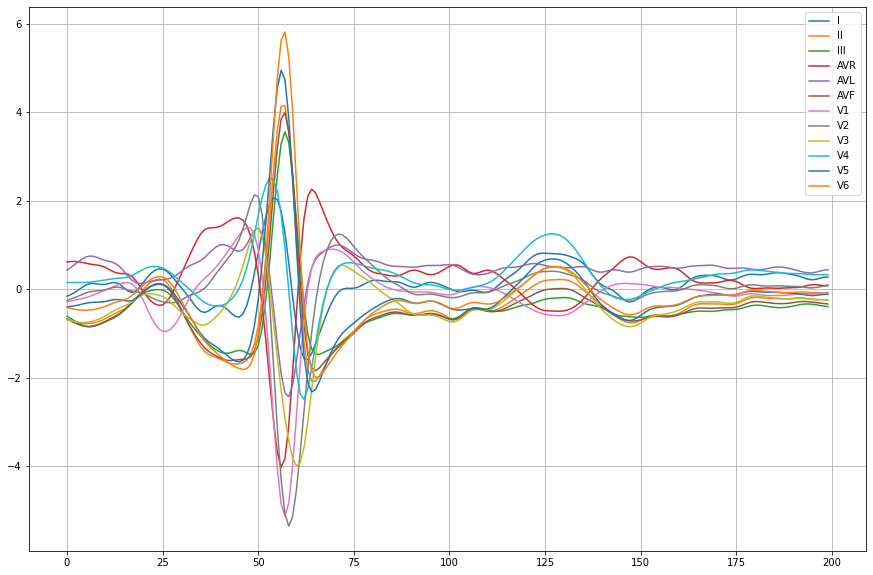

In [ ]:
name = ['I', 'II', 'III', 'AVR', 'AVL', 'AVF',
            'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
fig, ax = plt.subplots(figsize=(15, 10))
leads = prerpo_sig
x = leads[:][:200]
n = len(x)
ax.plot(x)
ax.grid()
plt.legend(name)
plt.show()

In [ ]:
# Read the file.
record = wf.rdsamp('drive/My Drive/ECG classification/Data/files/I08')
annotation = wf.rdann('drive/My Drive/ECG classification/Data/files/I08', 'atr')

# Info about the data.
print('Sampling frequency:', record[1].get('fs'))
print('Data shape:', record[0].shape)
print('Annotations:', len(annotation.num))

Sampling frequency: 257
Data shape: (462600, 12)
Annotations: 2131


In [ ]:
data_path = 'drive/MyDrive/ECG classification/Data/files/'
path = sorted(os.listdir(data_path))
all_data = []
all_anno_sym = []
all_anno_sample = []
i = 0
for  name in (path):
    splited_name = name.split('.')
    fn = splited_name[0]
    if 'atr' and 'dat' and 'hea' in splited_name:
        print('Loading file:', fn)
        # Read in the data
        record = wf.rdsamp(data_path+fn)
        annotation = wf.rdann(data_path+fn, 'atr')
        all_data.append(record[0])
        all_anno_sample.append(annotation.sample)
        all_anno_sym.append(annotation.symbol)
        # for j in range(len(annotation.num)):
          
        #   # all_anno_sym[i][j] = annotation.symbol[i]
        #   all_anno_sample.append([i,annotation.sample[j]])
        #   all_anno_sym.append(annotation.symbol[j])
        # i = i+1




Loading file: I03
Loading file: I04
Loading file: I05
Loading file: I06
Loading file: I07
Loading file: I08
Loading file: I09
Loading file: I10
Loading file: I11
Loading file: I12
Loading file: I13
Loading file: I14
Loading file: I15
Loading file: I16
Loading file: I17
Loading file: I18
Loading file: I19
Loading file: I20
Loading file: I21
Loading file: I22
Loading file: I23
Loading file: I24
Loading file: I25
Loading file: I26
Loading file: I27
Loading file: I28
Loading file: I29
Loading file: I30
Loading file: I31
Loading file: I32
Loading file: I33
Loading file: I34
Loading file: I35
Loading file: I36
Loading file: I37
Loading file: I38
Loading file: I39
Loading file: I40
Loading file: I41
Loading file: I42
Loading file: I43
Loading file: I44
Loading file: I45
Loading file: I46
Loading file: I47
Loading file: I48
Loading file: I49
Loading file: I50
Loading file: I51
Loading file: I52
Loading file: I53
Loading file: I54
Loading file: I55
Loading file: I56
Loading file: I58
Loading fi

In [ ]:
all_data = np.array(all_data)
all_anno_sample = np.array(all_anno_sample)

In [ ]:
print(all_data.shape,all_anno_sample.shape,len(all_anno_sym))

(72, 462600, 12) (72,) 72


In [ ]:
prepro_sig = []
labels_sample = []
labels_sym = []
for i in range(len(all_data)):
  try:
      prepro = Preproccess_Signals(all_data[i]) 
      prepro_sig.append(prepro)
      labels_sample.append(all_anno_sample[i])
      labels_sym.append(all_anno_sym[i])
  except ValueError:
      print(i,'is Unreadable file')

      pass


0 is Unreadable file
54 is Unreadable file


In [ ]:
prepro_sig = np.array(prepro_sig)
labels_sample = np.array(labels_sample)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [ ]:
np.save('/content/drive/MyDrive/ECG classification/ signalss.npy', prepro_sig)
np.save('/content/drive/MyDrive/ECG classification/ labels.npy', labels_sample)
np.save('/content/drive/MyDrive/ECG classification/ sym.npy', labels_sym)


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [ ]:
prepro_sig = np.load('/content/drive/MyDrive/ECG classification/ signalss.npy',allow_pickle=True)
labels_sample = np.load('/content/drive/MyDrive/ECG classification/ labels.npy',allow_pickle=True)
labels_sym = np.load('/content/drive/MyDrive/ECG classification/ sym.npy',allow_pickle=True)

In [ ]:
print(prepro_sig.shape,labels_sample.shape,len(labels_sym))

(70, 462600, 12) (70,) 70


In [ ]:
labels = []
signalss = []
sym = []
for i in range(len(labels_sample)):
  for j in range(len(labels_sample[i])):
    if labels_sample[i][j] > 120 :
      st_id = labels_sample[i][j] - 120
      en_id = labels_sample[i][j] + 130
      signall = prepro_sig[i][st_id:en_id]
      signalss.append(signall)
      labels.append(labels_sym[i][j])

In [ ]:
signalss = np.array(signalss)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [ ]:
labels_df = pd.DataFrame(labels)
labels_df.value_counts()

N    138028
V     19278
R      3173
A      1938
F       216
j        92
n        32
S        16
+         6
Q         4
B         1
dtype: int64

In [ ]:
data = []
sym = []
k = 0
for i in range(len(signalss)):
  if len(signalss[i]) == 250:
    if labels_df[0][i] == 'N' and k < 20000:
      data.append(signalss[i])
      sym.append(labels_df[0][i])
      k = k + 1
    elif labels_df[0][i] == 'V' or labels_df[0][i] =='R' or labels_df[0][i] == 'A':
      data.append(signalss[i])
      sym.append(labels_df[0][i])
  

In [ ]:
labels_df = pd.DataFrame(sym)
labels_df.value_counts()

N    20000
V    19275
R     3173
A     1937
dtype: int64

In [ ]:
data = np.array(data)
print(data.shape,len(sym))

(44385, 250, 12) 44385


In [ ]:
int_labels = []
for i in sym:
  if i == 'N':
    int_labels.append(0)
  elif i == 'V':
    int_labels.append(1)
  elif i == 'R':
    int_labels.append(2)
  elif i == 'A':
    int_labels.append(3)

In [ ]:
X = data
Y = int_labels

In [ ]:
np.save('/content/drive/MyDrive/ECG classification/ X.npy', X)
np.save('/content/drive/MyDrive/ECG classification/ Y.npy', Y)

In [ ]:
X_train , X_test, y_train, y_test = train_test_split(X,Y,test_size=0.3, random_state=42)

## CNN

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score, accuracy_score

from keras import optimizers, losses, activations, models
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from keras.layers import Dense, Input,GRU, Dropout, BatchNormalization,Convolution1D, MaxPool1D, Activation, GlobalMaxPool1D,ZeroPadding1D, GlobalAveragePooling1D, \
    concatenate
from sklearn.metrics import f1_score, accuracy_score
tf.reset_default_graph()
tf.Graph().as_default()

In [ ]:
X_train.shape

(31069, 250, 12)

In [ ]:


def get_model():
    inp = Input(shape=(250, 12))
    sig = ZeroPadding1D(1)(inp)
    sig = Convolution1D(32, 3 , strides= 1, kernel_initializer='he_normal', padding="same")(sig)
    sig = BatchNormalization(axis=1)(sig)
    sig = Activation('relu')(sig)
####################################################

    sig = ZeroPadding1D(1)(sig)
    sig = Convolution1D(32, 3 , strides= 1, kernel_initializer='he_normal', padding="same")(sig)
    sig = BatchNormalization(axis=1)(sig)
    sig = Activation('relu')(sig)
#####################################################


    sig = MaxPool1D(pool_size=2,strides=3, padding='same')(sig)
    sig = Dropout(rate=0.2)(sig)
######################################################

    sig = ZeroPadding1D(1)(sig)
    sig = Convolution1D(64, 3 , strides= 1, kernel_initializer='he_normal', padding="same")(sig)
    sig = BatchNormalization(axis=1)(sig)
    sig = Activation('relu')(sig)
####################################################

    sig = ZeroPadding1D(1)(sig)
    sig = Convolution1D(64, 3 , strides= 1, kernel_initializer='he_normal', padding="same")(sig)
    sig = BatchNormalization(axis=1)(sig)
    sig = Activation('relu')(sig)
#####################################################


    sig = MaxPool1D(pool_size=2,strides=3, padding='same')(sig)
######################################################

    sig = ZeroPadding1D(1)(sig)
    sig = Convolution1D(128, 3 , strides= 1, kernel_initializer='he_normal', padding="same")(sig)
    sig = BatchNormalization(axis=1)(sig)
    sig = Activation('relu')(sig)
####################################################

    sig = ZeroPadding1D(1)(sig)
    sig = Convolution1D(128, 3 , strides= 1, kernel_initializer='he_normal', padding="same")(sig)
    sig = BatchNormalization(axis=1)(sig)
    sig = Activation('relu')(sig)
#####################################################


    sig = MaxPool1D(pool_size=2,strides=3, padding='same')(sig)
######################################################

    sig = GRU(32)(sig)
    sig = Dense(4,activation='softmax')(sig)



    model = models.Model(inputs=inp, outputs=sig)
    opt = optimizers.Adam(0.001)

    model.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["acc"])
    model.summary()
    return model

cnn_model = get_model()

early = EarlyStopping(monitor="val_acc", mode="max", patience=5, verbose=1)
redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=3, verbose=2)
callbacks_list = [early, redonplat]  # early

history = cnn_model.fit(X_train, y_train, epochs=10, verbose=1,  validation_split=0.1,shuffle=True,callbacks=callbacks_list)

preds = cnn_model.predict(X_test)
pred_test = np.argmax(preds, axis=-1)
f1 = f1_score(y_test, pred_test, average="macro")
recall = recall_score(y_test,pred_test, average = 'macro')
prec = precision_score(y_test,pred_test, average='macro')
acc = accuracy_score(y_test, pred_test)

print("Test F1 score : %s "% f1)
print("Test Recall score : %s "% recall)
print("Test Precision score : %s "% prec)
print("Test accuracy score : %s "% acc)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 250, 12)           0         
_________________________________________________________________
zero_padding1d_1 (ZeroPaddin (None, 252, 12)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 252, 32)           1184      
_________________________________________________________________
batch_normalization_1 (Batch (None, 252, 32)           1008      
_________________________________________________________________
activation_1 (Activation)    (None, 252, 32)           0         
_________________________________________________________________
zero_padding1d_2 (ZeroPaddin (None, 254, 32)           0         
___________________________________________

In [ ]:
from keras.models import load_model

cnn_model.save('drive/MyDrive/ECG classification/cnn_model.h5')  


#cnn_model = load_model('my_model.h5')

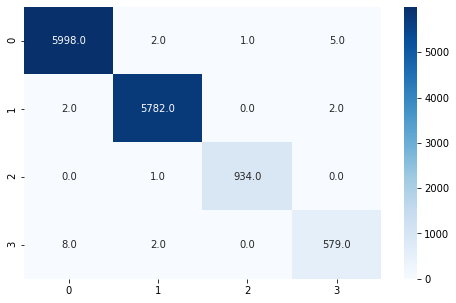

In [ ]:
cm= confusion_matrix(y_test,pred_test)
fig, ax = plt.subplots(figsize=(8,5)) 
sns.heatmap(cm,annot=True, fmt=".1f",cmap="Blues",ax=ax);

In [ ]:
fp_n = []
for i in range(4):
  for j in range(1,2):
    if cm[j][i] < 100:
      fp_n.append(cm[j][i])
fp = 0
for i in fp_n:
  fp = fp +i

In [ ]:
fn_n = []
for i in range(1):
  for j in range(1,4):
   fn_n.append(cm[j][i])
fn = 0
for i in fn_n:
  fn = fn +i



In [ ]:
recall_n = cm[0][0]/(cm[0][0]+fn)
pre_n = cm[0][0]/(cm[0][0]+fp)

In [ ]:
print('Recall score for Beat N : ',recall_n)
print('Precision score for Beat N : ', pre_n)
print('F1 score for Beat N : ', ((pre_n*recall_n)/(pre_n+recall_n))* 2)


Recall score for Beat N :  0.998335552596538
Precision score for Beat N :  0.9986679986679987
F1 score for Beat N :  0.9985017479607126


In [ ]:
fp_n = []
for i in range(4):
  for j in range(1,2):
    if cm[j][i] < 100:
      fp_n.append(cm[j][i])
fp = 0
for i in fp_n:
  fp = fp +i

fn_n = []
for i in range(1,2):
  for j in range(4):
    if cm[j][i] < 100:
      fn_n.append(cm[j][i])
fn = 0
for i in fn_n:
  fn = fn +i


In [ ]:
recall_v = cm[1][1]/(cm[1][1]+fn)
pre_v = cm[1][1]/(cm[1][1]+fp)


In [ ]:
print('Recall score for Beat V : ',recall_v)
print('Precision score for Beat V : ', pre_v)
print('F1 score for Beat V : ', ((pre_v *recall_v)/(pre_v+recall_v))* 2)


Recall score for Beat V :  0.9991359944703646
Precision score for Beat V :  0.9993086761147598
F1 score for Beat V :  0.9992223278320229


In [ ]:
fp_n = []
for i in range(4):
  for j in range(2,3):
    if cm[j][i] < 100:
      fp_n.append(cm[j][i])
fp = 0
for i in fp_n:
  fp = fp +i

fn_n = []
for i in range(2,3):
  for j in range(4):
    if cm[j][i] < 100:
      fn_n.append(cm[j][i])
fn = 0
for i in fn_n:
  fn = fn +i

In [ ]:
recall_r = cm[2][2]/(cm[2][2]+fn)
pre_r = cm[2][2]/(cm[2][2]+fp)

In [ ]:
print('Recall score for Beat R : ',recall_r)
print('Precision score for Beat R : ', pre_r)
print('F1 score for Beat R : ', ((pre_r *recall_r)/(pre_r+recall_r))* 2)


Recall score for Beat R :  0.9989304812834224
Precision score for Beat R :  0.9989304812834224
F1 score for Beat R :  0.9989304812834224


In [ ]:
fp_n = []
for i in range(4):
  for j in range(3,4):
    if cm[j][i] < 100:
      fp_n.append(cm[j][i])
fp = 0
for i in fp_n:
  fp = fp +i

fn_n = []
for i in range(3,4):
  for j in range(4):
    if cm[j][i] < 100:
      fn_n.append(cm[j][i])
fn = 0
for i in fn_n:
  fn = fn +i

In [ ]:
recall_a = cm[3][3]/(cm[3][3]+fn)
pre_a = cm[3][3]/(cm[3][3]+fp)

In [ ]:
print('Recall score for Beat A : ',recall_a)
print('Precision score for Beat A : ', pre_a)
print('F1 score for Beat A : ', ((pre_a *recall_a)/(pre_a+recall_a))* 2)


Recall score for Beat A :  0.9880546075085325
Precision score for Beat A :  0.9830220713073005
F1 score for Beat A :  0.985531914893617


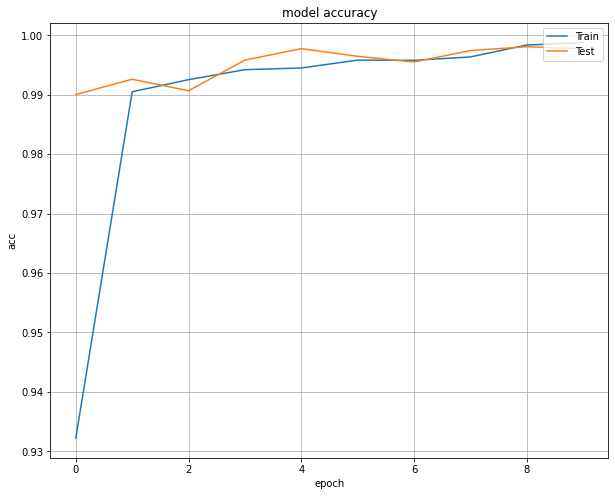

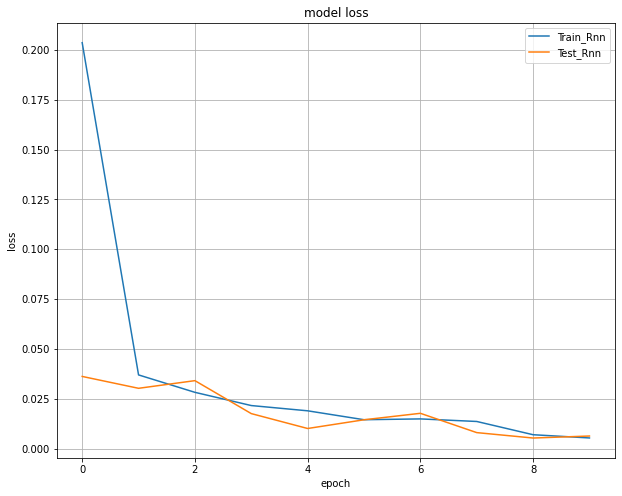

In [ ]:

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.rcParams["figure.figsize"] = (10,8)
plt.grid()
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train_Rnn', 'Test_Rnn'], loc='upper right')
plt.rcParams["figure.figsize"] = (10,8)
plt.grid()
plt.show()

##___________________________________________________________________________________________

DONE

# -------------------------------------------------------------------------------